# Main Aggregation Script - calls lab.py and crystals.py

In [1]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

In [2]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt

In [3]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='20000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(10)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://169.226.65.50:41355 Dashboard: http://169.226.65.50:44903/status,Cluster Workers: 10 Cores: 10 Memory: 209.70 GB


# Initialize databases for queries

In [61]:
files = ['sqlite:///'+f for f in glob.glob("db_files/IPAS_*_lastmono.sqlite")]
tables = ['aggregates', 'crystals']

In [62]:
%%time

df=[]
for table in tables:
    
    #read tables in parallel on client 
    read_files = [dask.delayed(dd.read_sql_table)(table=table, uri=file, index_col='id') for file in files]
    
    compute_read = client.compute(read_files)
    print('done with compute')
    ddfs = client.gather(compute_read)
    print('done with gather')
    #concatenate all sqlite files vertically (axis=0 default) (same columns)
    gathered_reads = client.scatter(ddfs)
    ddf = client.submit(dd.concat, gathered_reads).result()
    print('done with submit')
    #append combined dask df for each table
    df.append(ddf)


done with compute
done with gather
done with submit
done with compute
done with gather
done with submit
CPU times: user 4.4 s, sys: 304 ms, total: 4.7 s
Wall time: 58 s


In [63]:
%time df_concat = dd.concat([df[0], df[1]], axis=1)

CPU times: user 9.75 ms, sys: 0 ns, total: 9.75 ms
Wall time: 10.3 ms


/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [64]:
df_concat.agg_r = np.power((np.power(df_concat.a, 2) * df_concat.c), (1./3.))
df_concat.agg_phi = 1/df_concat.agg_phi

In [65]:
def query_r_5000(df):
    return df[df.agg_r < 5000]

df_concat = df_concat.map_partitions(query_r_5000)
#len(df_concat) #86% of dataset

In [66]:
df_repart = df_concat.repartition(partition_size="100MB").persist()
df_repart.npartitions

50

# MAIN

In [67]:
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
rand_orient = True  #randomly orient the seed crystal and new crystal: uses first random orientation
save_plots = False     #saves all histograms to path with # of aggs and minor/depth folder

#Note, there may be a shape parameter erlang distribution run time warning occasionally if warning filter
#is turned off, disregard it
#warnings.filterwarnings("ignore")


In [68]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df.ncrystals.mean().compute())
    return avg_ncrystals

def concatenate_points(agg):
    points = []
    ncrystals = agg.ncrystals.values[0]
    agg_id = agg.agg_id.values[0]
    #print('ncrystals, phi, r, agg_id')

    while ncrystals >= 2:
        query = df_repart[(df_repart.r == agg.r.values[0]) & (df_repart.phi == agg.phi.values[0]) & \
                     (df_repart.ncrystals == ncrystals) & (df_repart.agg_id == agg_id)].compute()

        #print(query.ncrystals.values[0], query.phi.values[0], query.r.values[0], query.agg_id.values[0])

        points.append(pickle.loads(query.points.values[0]))
        ncrystals -= 1
        agg_id -= 1

    cluster_points = np.concatenate(points)
    cluster_points = np.reshape(cluster_points, (int(np.shape(cluster_points)[0]/12), 12))
    cluster_points = np.array(cluster_points, dtype=[('x', float), ('y', float), ('z', float)])        
        
    return cluster_points

In [69]:
def concatenate_points_all(agg):

    ncrystals = agg.ncrystals    
    #print('ncrystals', ncrystals)
    agg_id = agg.agg_id
    #print('ncrystals, phi, r, agg_id', ncrystals, agg_id, agg_id-ncrystals)
    
    query = df_repart[(df_repart.r == agg.r) & (df_repart.phi == agg.phi) & \
                     (df_repart.ncrystals >= 2) & (df_repart.ncrystals <= ncrystals) &\
                     (df_repart.agg_id <= agg_id) & (df_repart.agg_id >= agg_id-ncrystals)].compute()
    
    cluster = ipas.Cluster_Calculations(agg)
    hold_points = []
    for crys in query.itertuples():
        for points in pickle.loads(crys.points):
            hold_points.append(points)
        #print('hold points', hold_points)

    #cluster.points = np.concatenate(hold_points)
    cluster.points = np.reshape(hold_points, (int(np.shape(hold_points)[0]/12), 12))
    cluster.points = np.array(cluster.points, dtype=[('x', float), ('y', float), ('z', float)])        
        
#     points = np.concatenate(hold_points)
#     points = np.reshape(points, (int(np.shape(cluster.points)[0]/12), 12))
#     points = np.array(points, dtype=[('x', float), ('y', float), ('z', float)])    
  
    return cluster

In [74]:
def main():
    
    output = []
    hold_clusters  = np.empty((20,20,301), dtype=object)
    res, phi_bins = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
    print(phi_bins)
    
    for i in range(19,len(phi_bins)-1):
        
        #print('phi_bin = ', phi_bins[i], phi_bins[i+1])
        #return a df that only queries within an aspect ratio bin
        df_phi = df_repart[(df_repart.agg_phi > phi_bins[i]) & (df_repart.agg_phi < phi_bins[i+1]) & \
                          (df_repart.ncrystals > 2)]  #to ensure at least 2 crystals within agg since ncrystals=1 not in db
        #now break that aspect ratio bin into 20 equal r bins
        res, r_bins = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)
        print(r_bins)

        for r in range(len(r_bins)-1):
            print('i, r ',i, r)

            print('r = ', r_bins[r], r_bins[r+1])
            df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) &\
                            (df_phi.ncrystals > 2)].compute() 

            #print(df_repart.id.value_counts().compute().head(30))         

            start_time = time.time()
            
            samples = df_r.sample(301)
            
            start_time = time.time()
            count=0
            for agg in samples.itertuples():
                cluster = concatenate_points_all(agg)
                #print(cluster.points)
                hold_clusters[i,r,count] = cluster
                count+=1
            print('time to concatenate all pts = ', (time.time()-start_time))

#             delayeds = []
#             for agg in samples.itertuples():
#                 delayeds.append(dask.delayed(concatenate_points_all)(agg))
#             delayeds = client.compute(delayeds)
#             hold_clusters[i,r,:] = client.gather(delayeds)
#             print('time to concatenate all pts = ', (time.time()-start_time))
            ipas.collect_clusters(hold_clusters[i,r,:], rand_orient=rand_orient)
            #output.append(dask.delayed(ipas.collect_clusters)(hold_clusters[i,r,:], rand_orient=rand_orient)) 
    
    start_time = time.time()
    output = client.compute(output)
    output = client.gather(output)
    print('time to collect = ', (time.time()-start_time))
    print('done gathering!')
            #%time output.append(ipas.collect_clusters(hold_clusters[i,r,:], rand_orient=rand_orient))
    
    return output, hold_clusters
    

[7.89112295e-03 1.79716791e-01 2.09389614e-01 2.34998400e-01
 2.59971786e-01 2.85986967e-01 3.14153406e-01 3.47995404e-01
 3.92322212e-01 4.61465475e-01 6.46893773e-01 1.51597541e+00
 1.70966171e+00 1.89914566e+00 2.11461587e+00 2.38814542e+00
 2.74107065e+00 3.19470728e+00 3.81030291e+00 4.78133309e+00
 1.31207007e+02]
[1.93674364e+00 1.25736544e+01 2.16930309e+01 3.11891070e+01
 4.12075520e+01 5.15890313e+01 6.25364850e+01 7.48646015e+01
 9.49076330e+01 1.65376775e+02 2.54520660e+02 3.51250641e+02
 4.54299561e+02 5.65823310e+02 7.02485451e+02 9.23928058e+02
 1.77073523e+03 2.47068879e+03 3.20096664e+03 4.06768945e+03
 4.99991238e+03]
i, r  19 0
r =  1.9367436430512242 12.573654353306418
time to concatenate all pts =  52.16293978691101


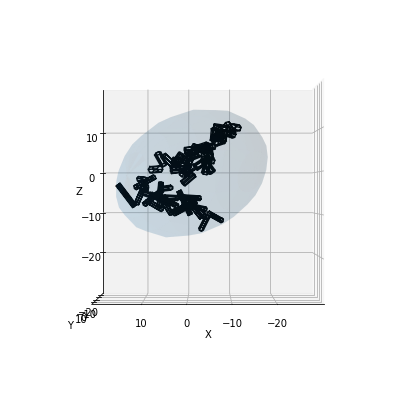

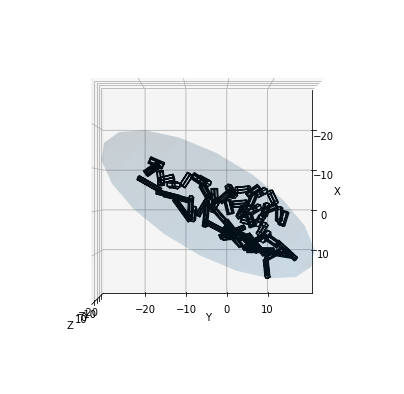

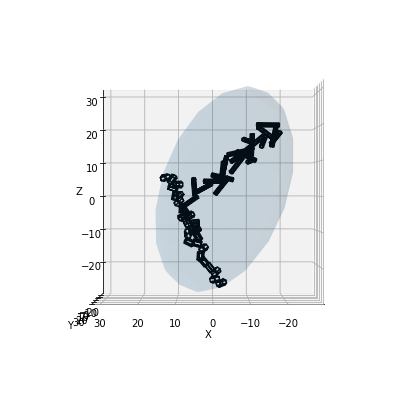

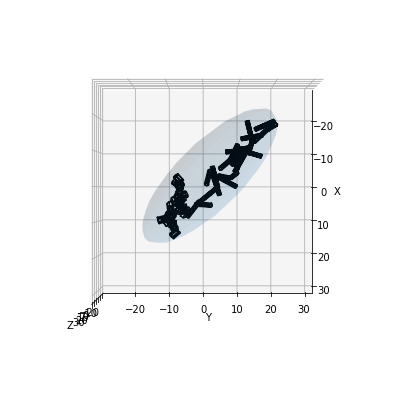

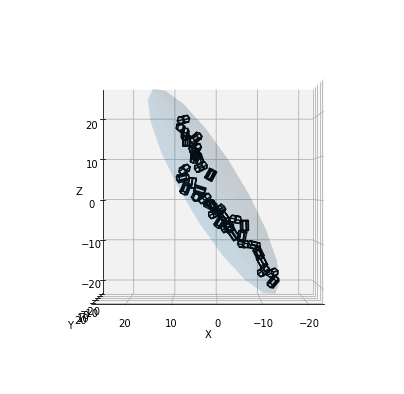

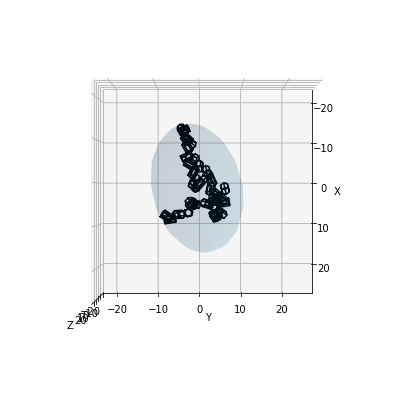

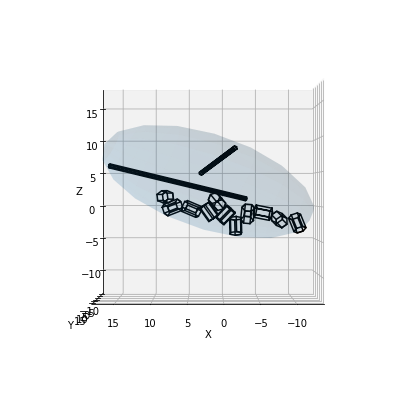

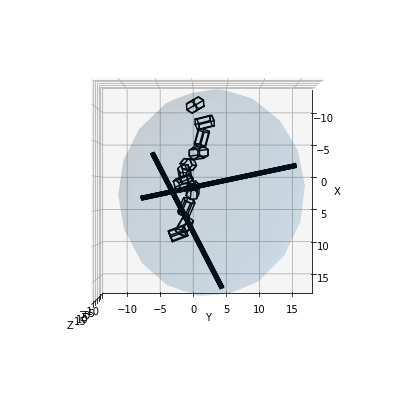

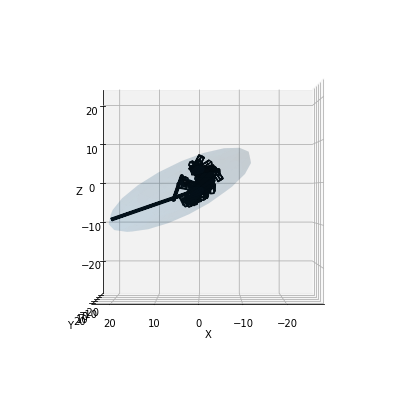

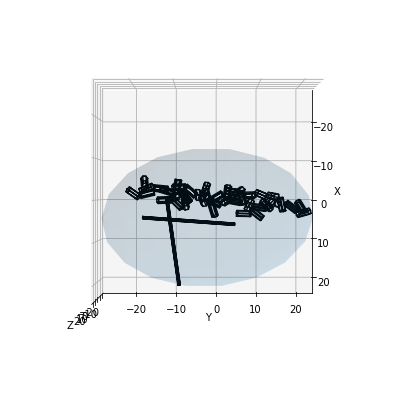

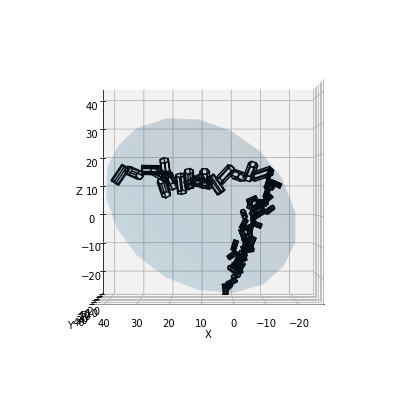

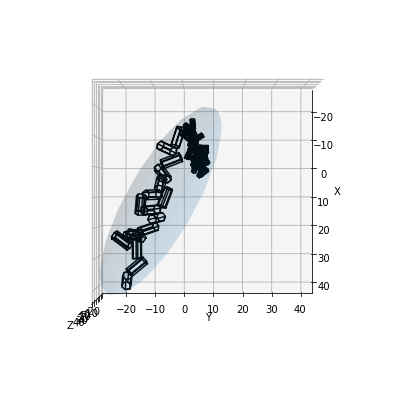

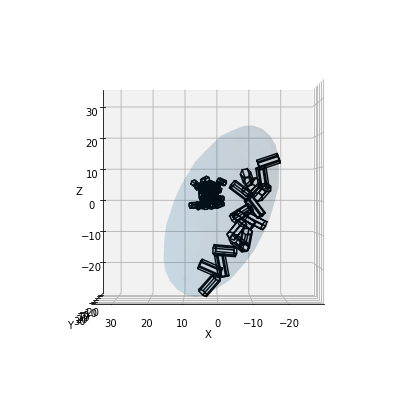

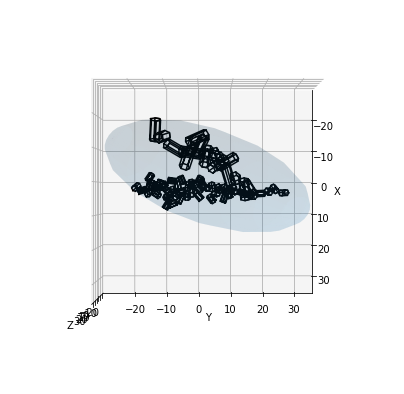

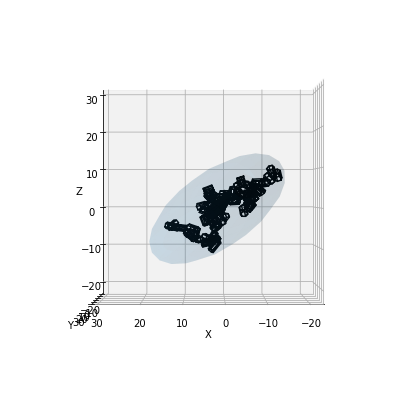

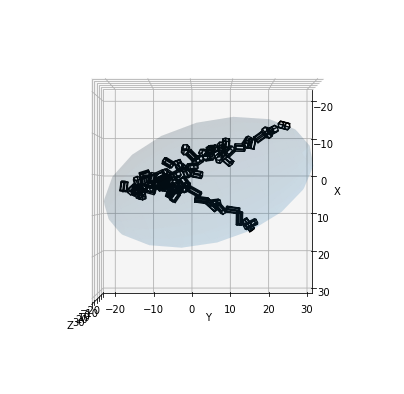

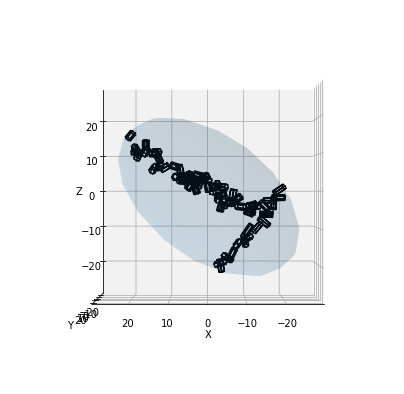

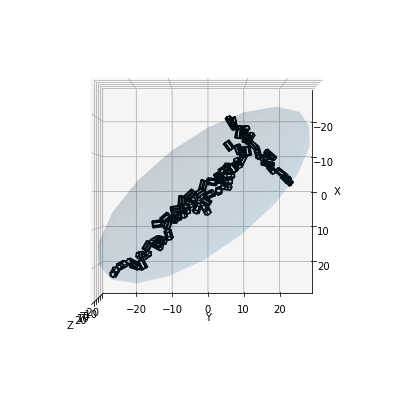

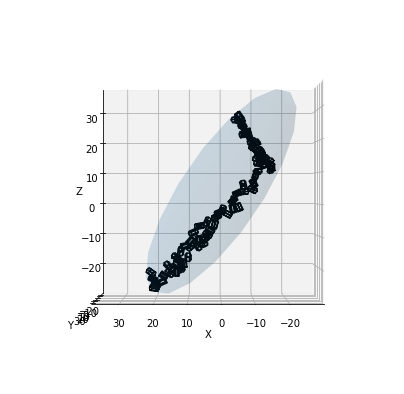

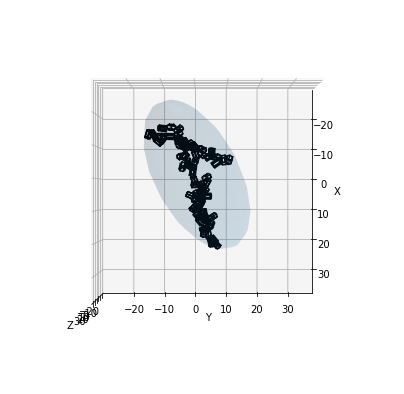

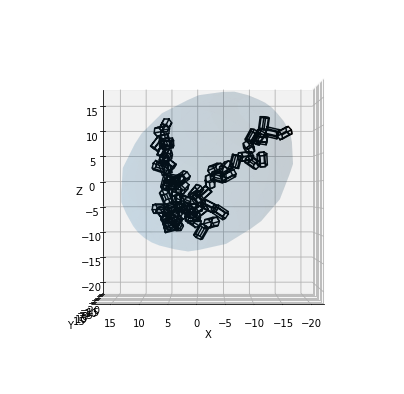

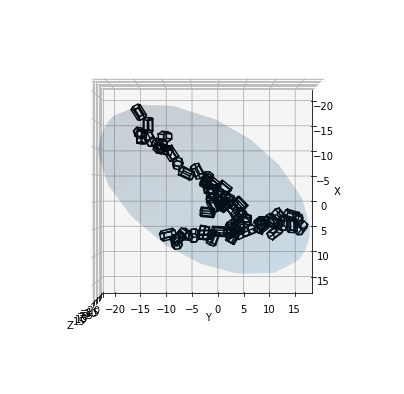

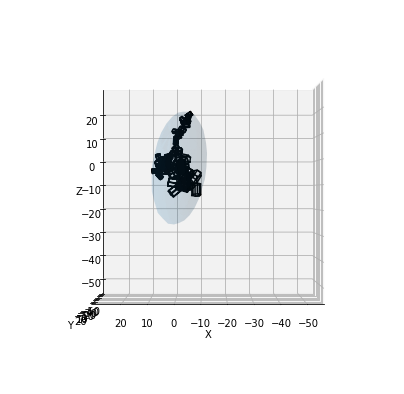

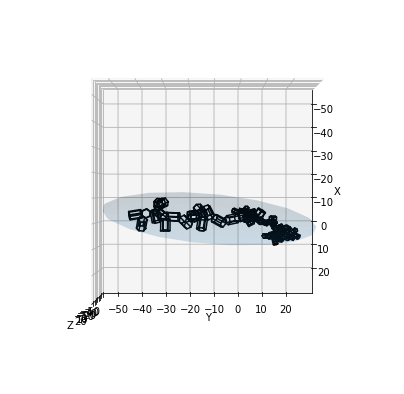

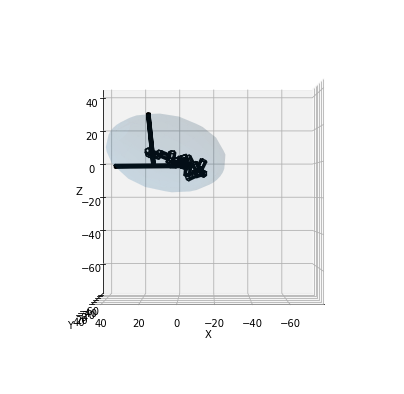

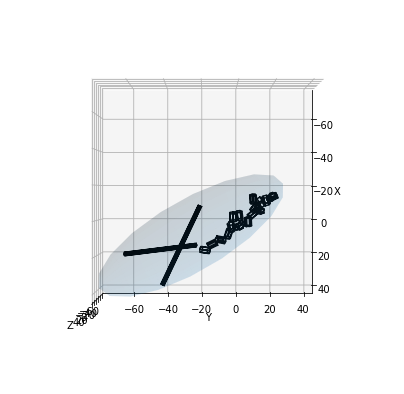

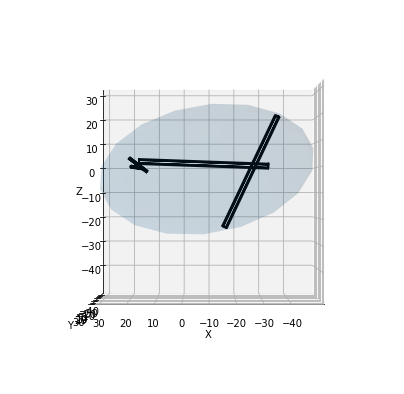

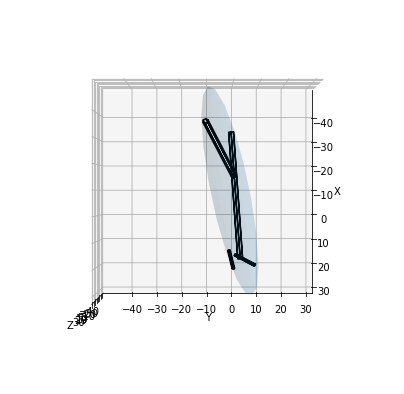

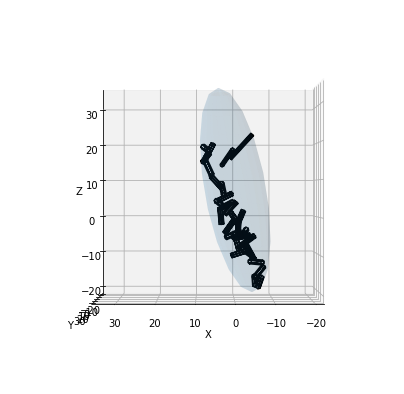

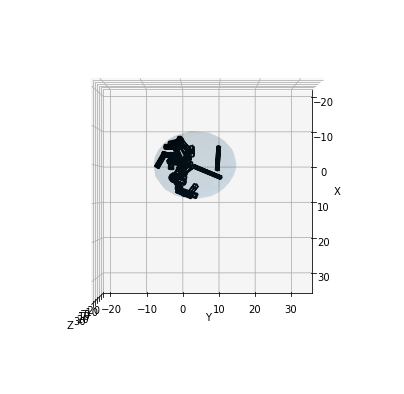

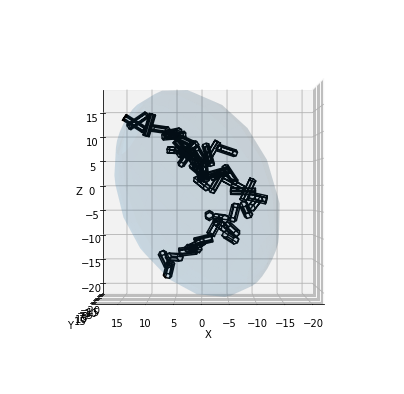

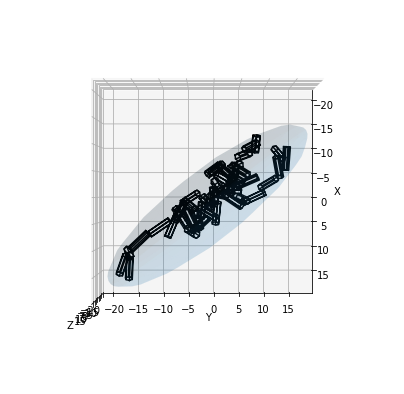

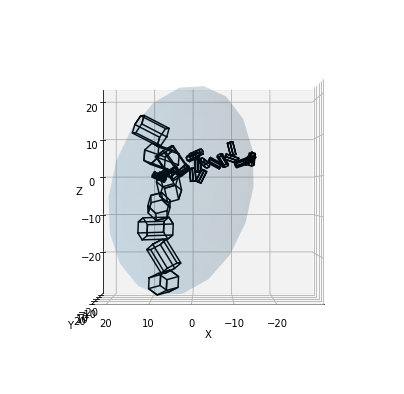

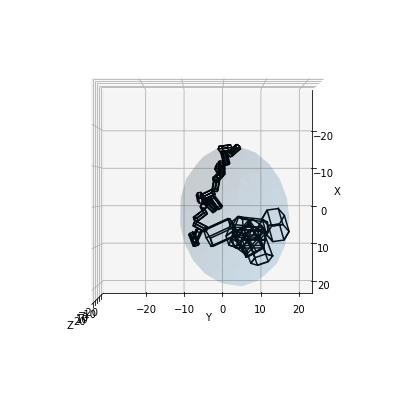

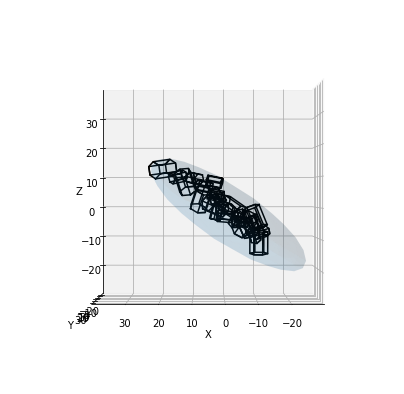

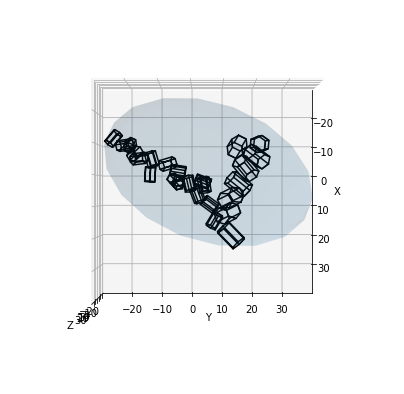

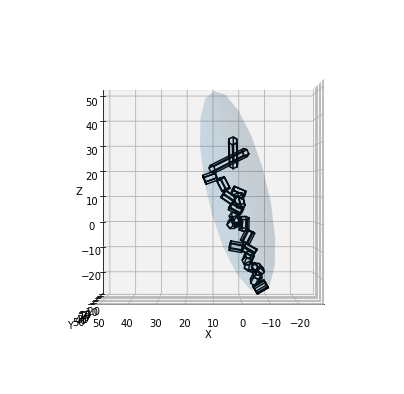

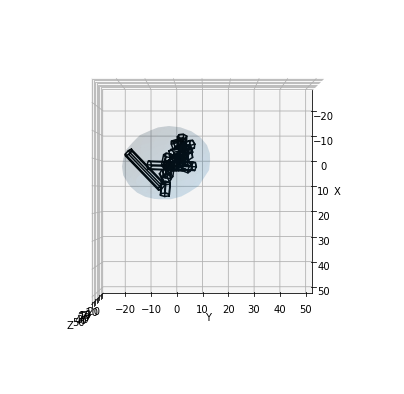

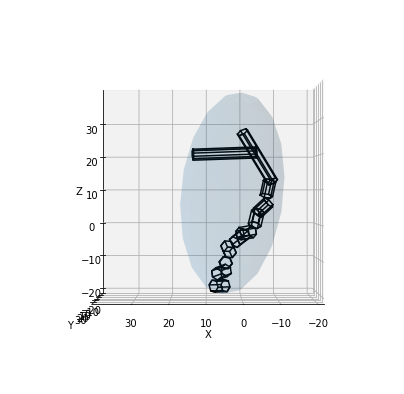

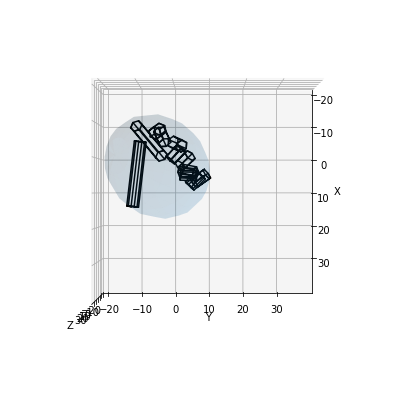

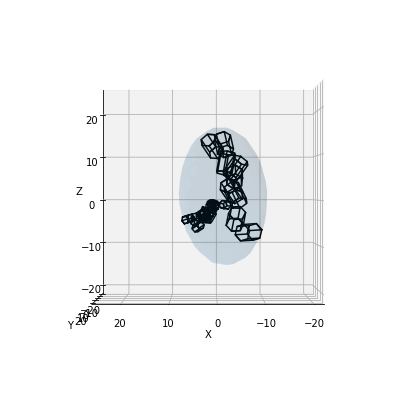

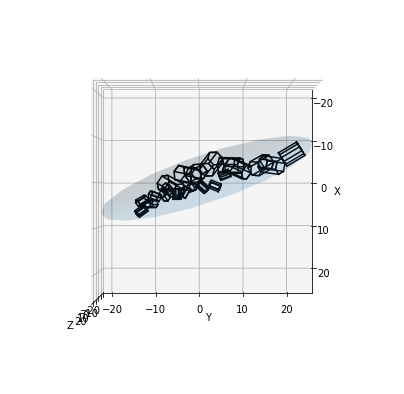

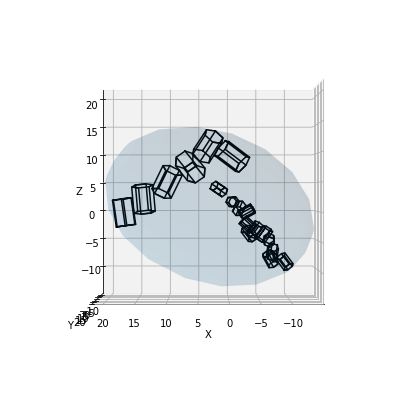

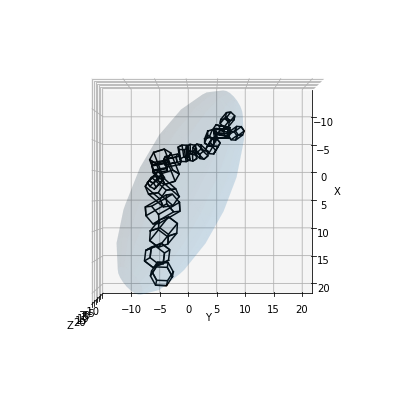

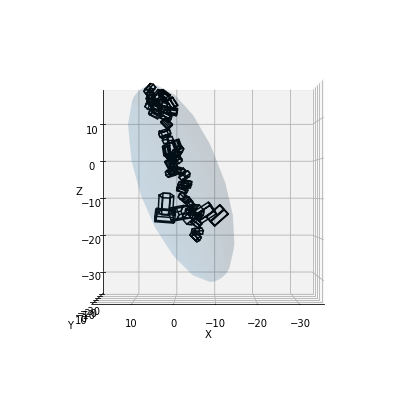

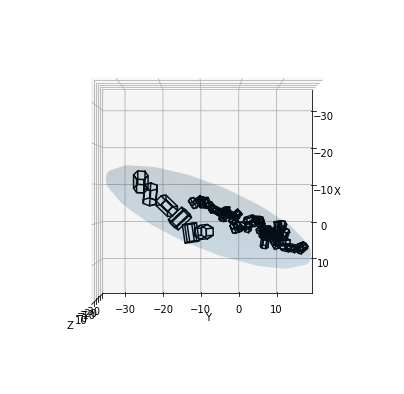

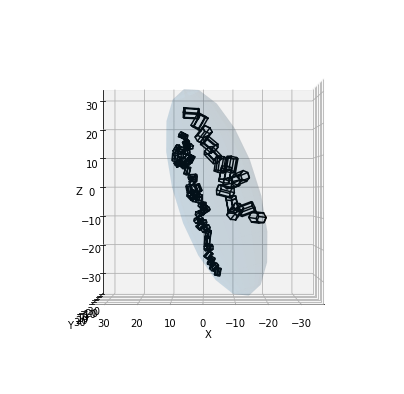

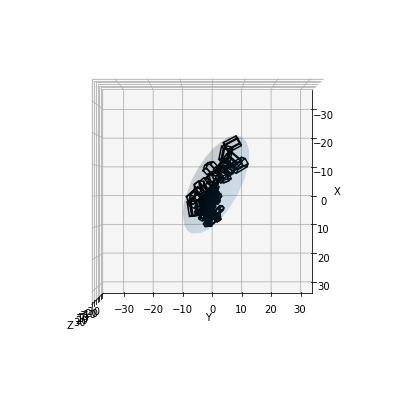

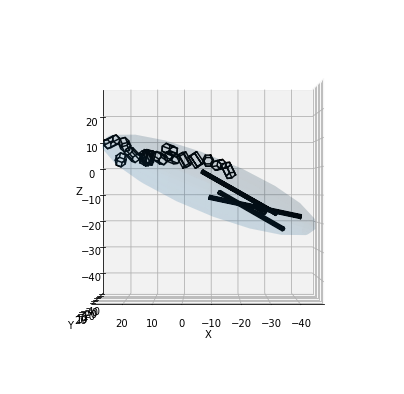

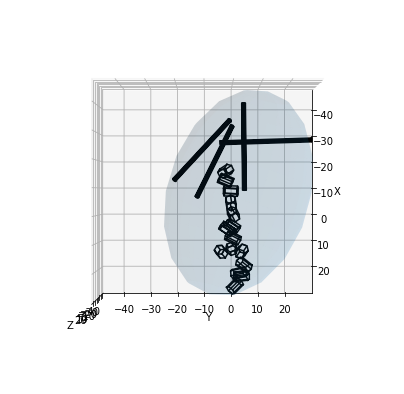

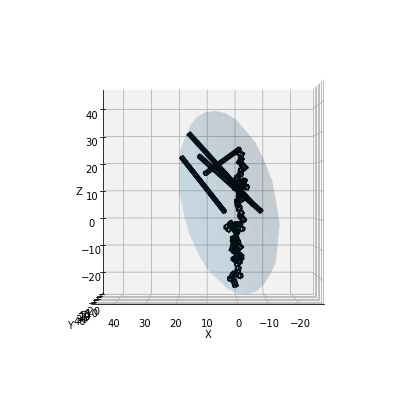

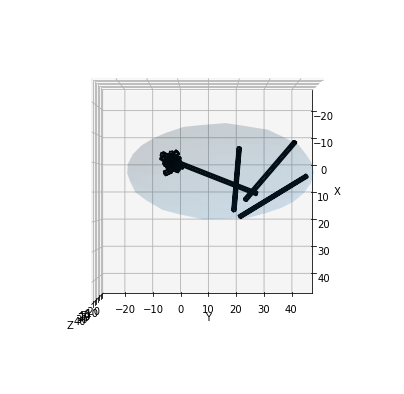

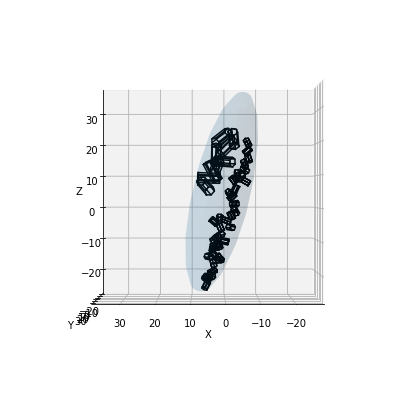

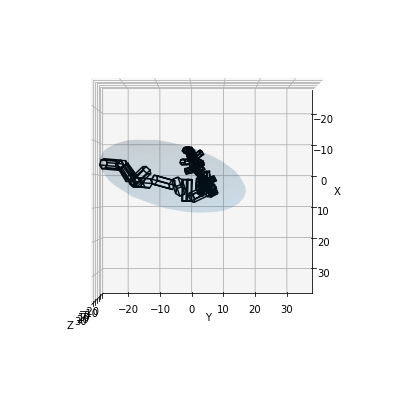

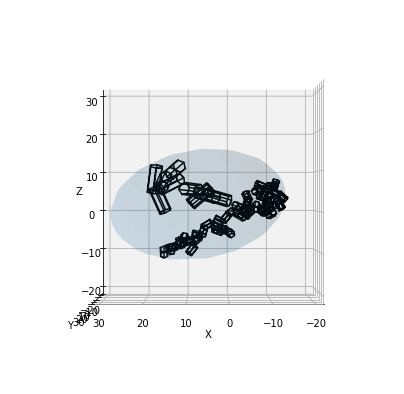

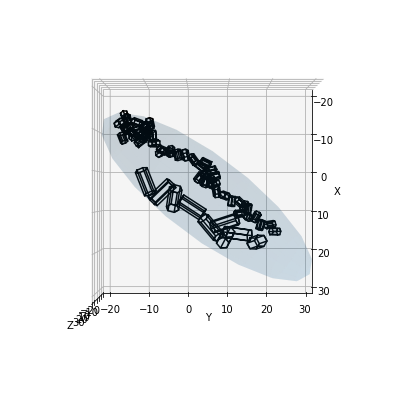

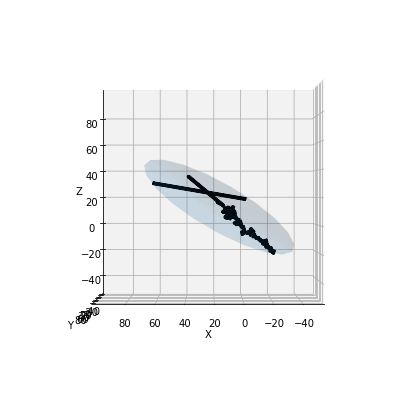

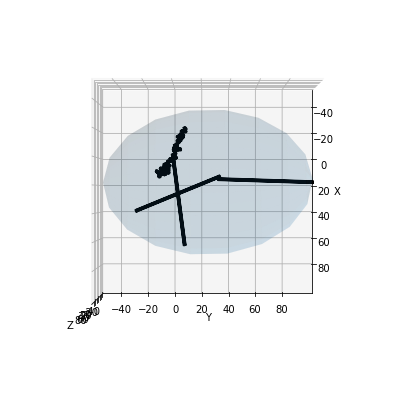

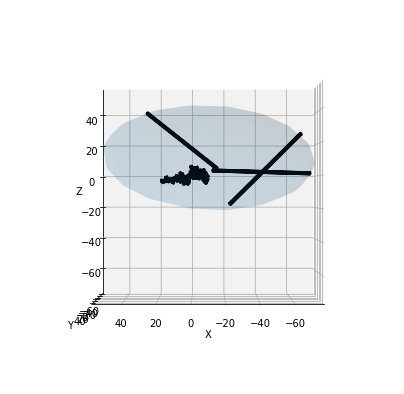

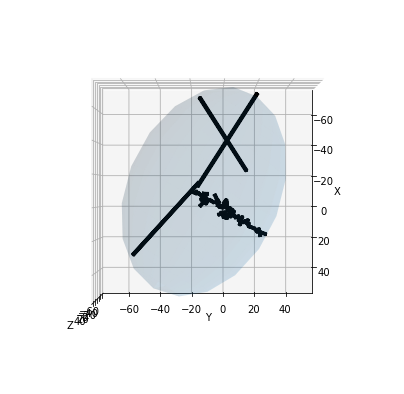

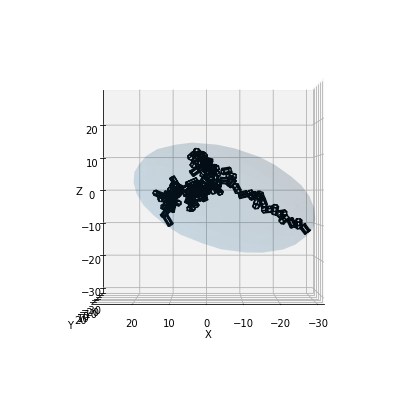

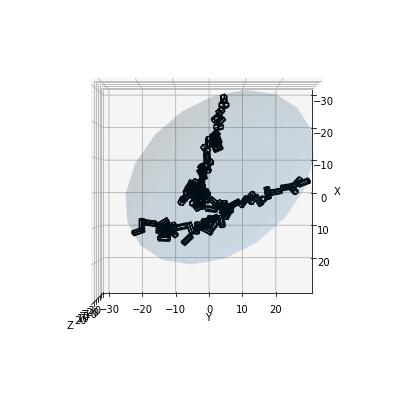

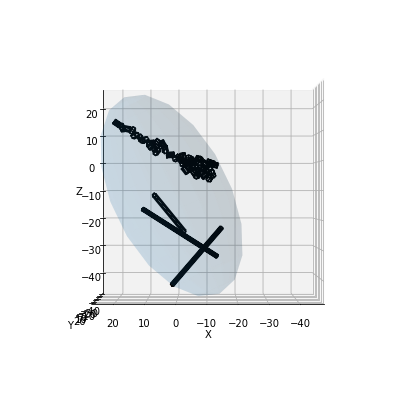

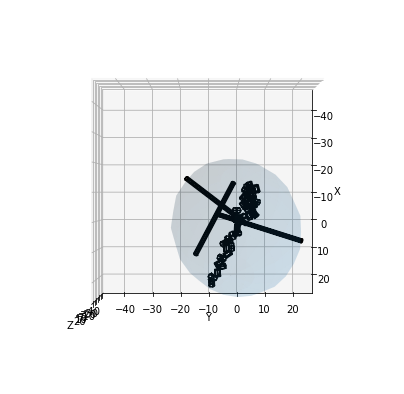

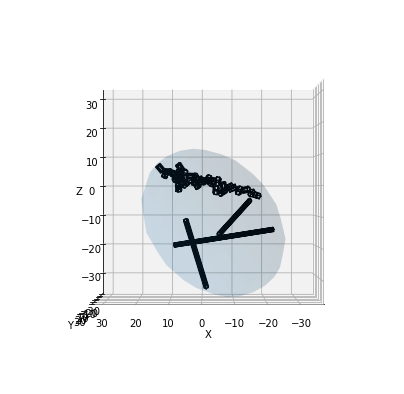

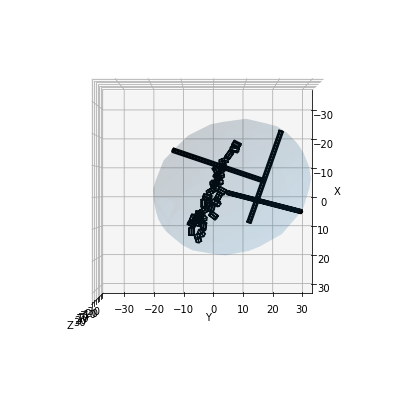

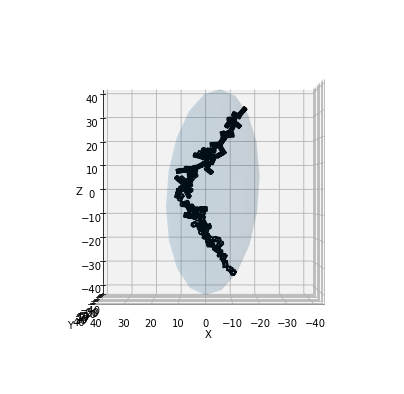

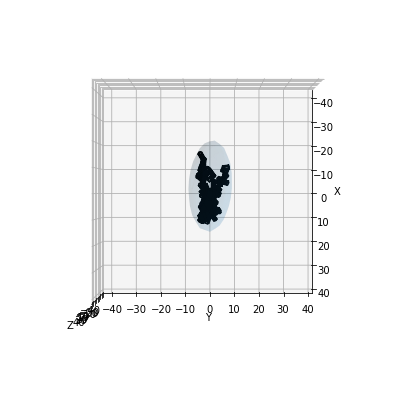

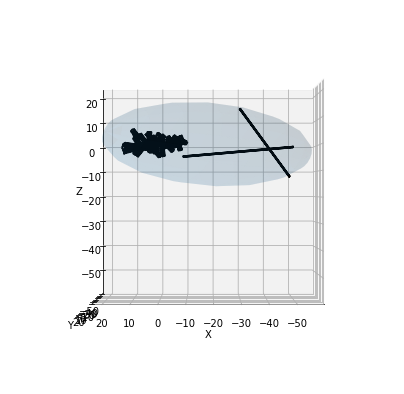

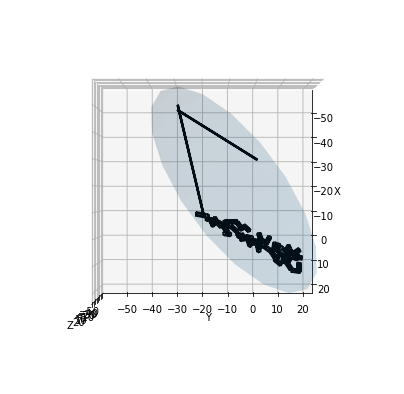

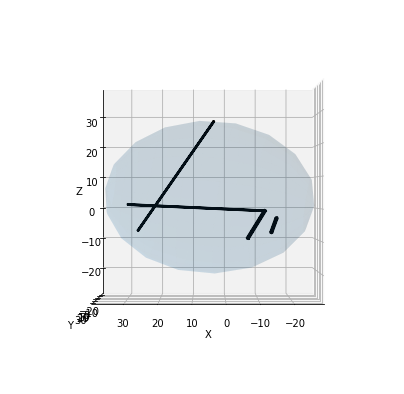

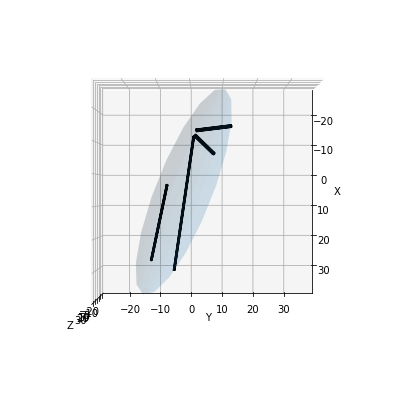

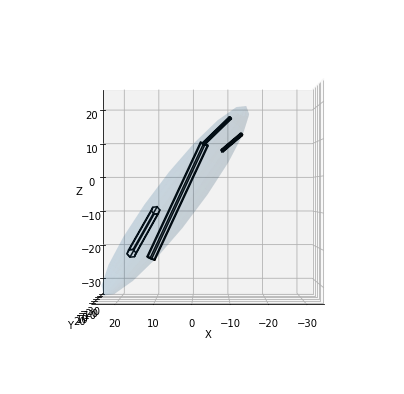

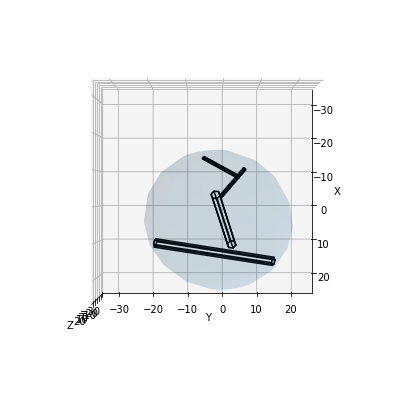

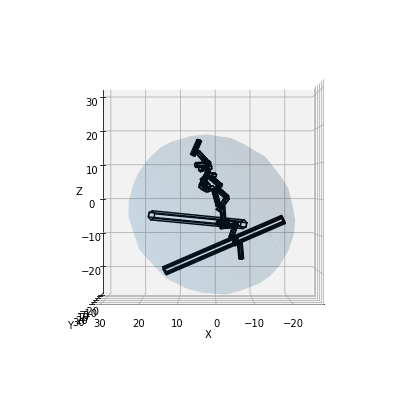

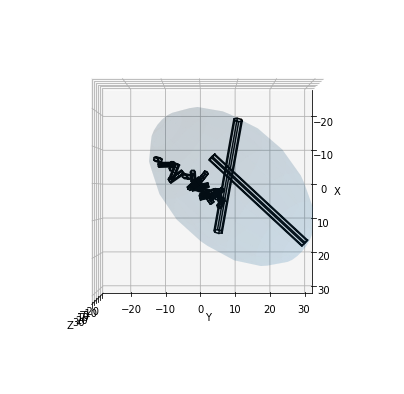

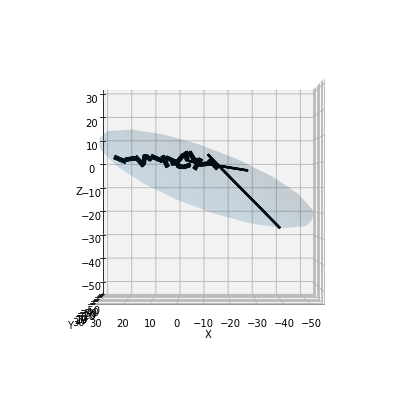

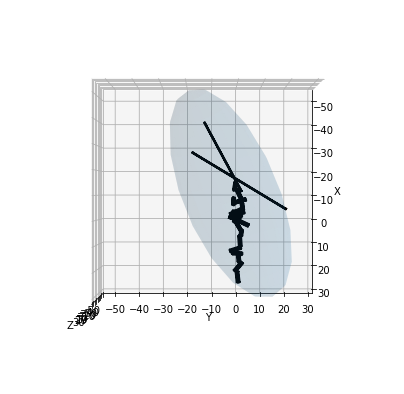

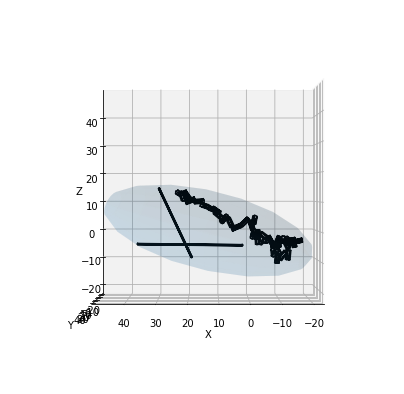

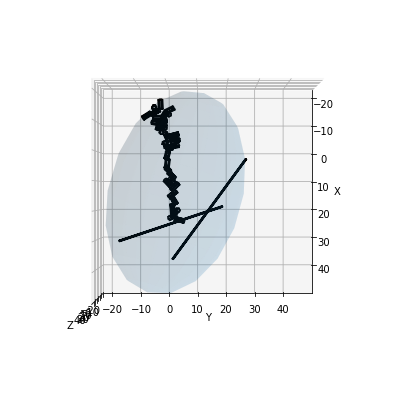

KeyboardInterrupt: 

In [75]:
output, hold_clusters = main() 

In [ ]:
with parallel_backend("loky"):
    output = Parallel(n_jobs=-1)(delayed(ipas.collect_clusters)(cluster, rand_orient=rand_orient) for cluster in clusters)
    print(output)   

distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('repartition-100000000-b9b6af723c5235062ffd2a9b234c9fb0', 28)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('repartition-100000000-b9b6af723c5235062ffd2a9b234c9fb0', 28)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('repartition-100000000-b9b6af723c5235062ffd2a9b234c9fb0', 11)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('repartition-100000000-b9b6af723c5235062ffd2a9b234c9fb0', 11)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('repartition-100000000-b9b6af723c5235062ffd2a9b234c9fb0', 36)"}
distributed.scheduler - CRITICAL - Tried writing to closed comm: {'op': 'lost-data', 'key': "('repartition-100000000-b9b6af723c5235062ffd2a9b234c9fb0', 36)"}
distributed.scheduler - CRITICAL - Tried writing to 

In [41]:
filename = 'instance_files/instance_db_aggagg_rand_returnclus1'
filehandler = open(filename, 'wb')
pickle.dump(output, filehandler)
filehandler.close()


In [42]:
filename = 'instance_files/pulled_clusters_rand1'
filehandler = open(filename, 'wb')
pickle.dump(hold_clusters, filehandler)
filehandler.close()
print('finished!')

finished!


In [40]:
#print(output)
#print('computing...')
start_time = time.time()
#b1 = client.compute(output, scheduler='distributed') 

clusters = iter(output)
futures = [client.submit(ipas.collect_clusters, list(next(clusters)), rand_orient=rand_orient) for i in range(4)]
ac = as_completed(futures)

b1=[]
for finished_future in ac:
    # submit new future 
    try:
        print('submiting a new future')
        new_future = client.submit(ipas.collect_clusters, list(next(clusters)), rand_orient=rand_orient)
        ac.add(new_future)
    except StopIteration:
        pass
    b1.append(finished_future.result())


#print('-------------gathering-----------')
#b1 = client.gather(b1)
print('time to collect = ', (time.time()-start_time))



KeyboardInterrupt: 

In [34]:
if __name__ == '__main__':

    %time b1 = main() 

    filename = 'instance_files/instance_db_aggagg_flat'
    filehandler = open(filename, 'wb')
    %time pickle.dump(b1, filehandler)
    filehandler.close()
    print('finished!')

i, r  0 0
r =  1.7487839568275625 13.844468606238443
time to concatenate all pts =  1.5152053833007812
i, r  0 1
r =  13.844468606238443 23.236377210240864


KeyboardInterrupt: 

NameError: name 'b1' is not defined

finished!
